# 作業 : (Kaggle)鐵達尼生存預測
https://www.kaggle.com/c/titanic

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 觀察均值編碼的效果

# [作業重點]
- 仿造範例, 完成標籤編碼與均值編碼搭配邏輯斯迴歸的預測
- 觀察標籤編碼與均值編碼在特徵數量 / 邏輯斯迴歸分數 / 邏輯斯迴歸時間上, 分別有什麼影響 (In[3], Out[3], In[4], Out[4]) 

# 作業1
* 請仿照範例，將鐵達尼範例中的類別型特徵改用均值編碼實作一次

In [1]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy, time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

data_path = '/Users/xiehuizhu/Downloads/2020ML/Day_007/'
df_train = pd.read_csv(data_path + 'titanic_train.csv')
df_test = pd.read_csv(data_path + 'titanic_test.csv')

train_Y = df_train['Survived']
ids = df_test['PassengerId']
df_train = df_train.drop(['PassengerId', 'Survived'] , axis=1)
df_test = df_test.drop(['PassengerId'] , axis=1)
train_num = train_Y.shape[0]
df = pd.concat([df_train,df_test])
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
num_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype != 'object':
        num_features.append(feature)
print(f'{len(num_features)} Numeric Features: {num_features}\n')
df_res = df[num_features]
df_res.head()

5 Numeric Features: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']



,Pclass,Age,SibSp,Parch,Fare
0,3,22.0,1,0,7.2500
1,1,38.0,1,0,71.2833
2,3,26.0,0,0,7.9250
3,1,35.0,1,0,53.1000
4,3,35.0,0,0,8.0500


In [3]:
df_res.corr()

,Pclass,Age,SibSp,Parch,Fare
Pclass,1.000000,-0.408106,0.060832,0.018322,-0.558629
Age,-0.408106,1.000000,-0.243699,-0.150917,0.178740
SibSp,0.060832,-0.243699,1.000000,0.373587,0.160238
Parch,0.018322,-0.150917,0.373587,1.000000,0.221539
Fare,-0.558629,0.178740,0.160238,0.221539,1.000000


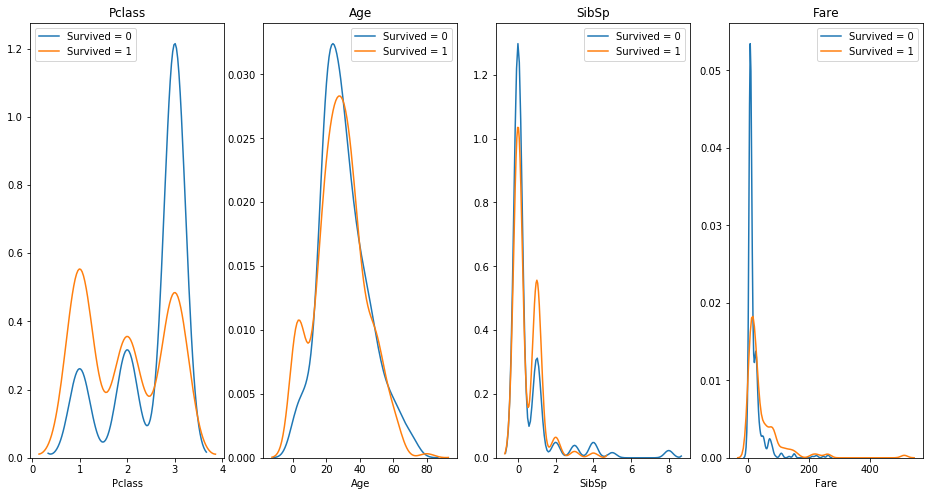

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

df_res = df_res.drop(['Parch'], axis = 1)
ncol = df_res.shape[1]
data = pd.concat([df_res[:train_num], train_Y], axis = 1)
plt.figure(figsize = (16, 8))
for num in range(len(df_res.columns)):
    plt.subplot(1, ncol, num + 1)
    sns.distplot(data[data['Survived'] == 0][data.columns[num]], label = 'Survived = 0', hist = False)
    sns.distplot(data[data['Survived'] == 1][data.columns[num]], label = 'Survived = 1', hist = False)
    plt.title(str(data.columns[num]))
plt.show()

In [5]:
#只取類別值 (object) 型欄位, 存於 object_features 中
object_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'object':
        object_features.append(feature)
print(f'{len(object_features)} Categorical Features : {object_features}\n')

# 只留類別型欄位
df = df[object_features]
df = df.fillna('None')
train_num = train_Y.shape[0]
df.head()

5 Categorical Features : ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']



,Name,Sex,Ticket,Cabin,Embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,None,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,None,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
4,"Allen, Mr. William Henry",male,373450,None,S


In [6]:
for c in df.columns:
    print(f'size: \n{df[c].value_counts()}\n')

size: 
Kelly, Mr. James                                               2
Connolly, Miss. Kate                                           2
Zakarian, Mr. Ortin                                            1
Torber, Mr. Ernst William                                      1
Svensson, Mr. Johan                                            1
                                                              ..
Silverthorne, Mr. Spencer Victor                               1
Ford, Mr. Edward Watson                                        1
McCarthy, Mr. Timothy J                                        1
Sincock, Miss. Maude                                           1
Cassebeer, Mrs. Henry Arthur Jr (Eleanor Genevieve Fosdick)    1
Name: Name, Length: 1307, dtype: int64

size: 
male      843
female    466
Name: Sex, dtype: int64

size: 
CA. 2343        11
CA 2144          8
1601             8
S.O.C. 14879     7
347077           7
                ..
113050           1
240929           1
111320           1


# 作業2
* 觀察鐵達尼生存預測中，均值編碼與標籤編碼兩者比較，哪一個效果比較好? 可能的原因是什麼?

In [7]:
# 對照組 : 標籤編碼 + 邏輯斯迴歸
df_temp = pd.DataFrame()
for c in df.columns:
    df_temp[c] = LabelEncoder().fit_transform(df[c])
train_X = df_temp[:train_num]
estimator = LogisticRegression()
start_time = time.time()
print(f'shape: {train_X.shape}')
print(f'score: {cross_val_score(estimator, train_X, train_Y, cv = 5).mean()}')
print(f'time: {time.time() - start_time} sec')

shape: (891, 5)
score: 0.7800138095537004
time: 0.14096999168395996 sec


In [8]:
data = pd.concat([df[:train_num], train_Y], axis = 1)
mean_df = data.groupby('Embarked')['Survived'].mean().reset_index()
mean_df
data.head()

,Name,Sex,Ticket,Cabin,Embarked,Survived
0,"Braund, Mr. Owen Harris",male,A/5 21171,None,S,0
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C,1
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,None,S,1
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S,1
4,"Allen, Mr. William Henry",male,373450,None,S,0


In [9]:
# 均值編碼 + 邏輯斯迴歸
data = pd.concat([df[:train_num], train_Y], axis = 1)
for c in df.columns:
    mean_df = data.groupby([c])['Survived'].mean().reset_index()
    mean_df.columns = [c, f'{c}_mean']
    data = pd.merge(data, mean_df, on = c, how = 'left')
    data = data.drop(c, axis = 1)
data = data.drop(['Survived'], axis = 1)
estimator = LogisticRegression()
start_time = time.time()
print(f'shape: {data.shape}')
print(f'score: {cross_val_score(estimator, data, train_Y, cv = 5).mean()}')
print(f'time: {time.time() - start_time} sex')

shape: (891, 5)
score: 1.0
time: 0.03712201118469238 sex


使用標籤編碼與均值編碼後，特徵數量一樣。
時間上標籤編碼所需時間比較多，應該是因為均值編碼後特徵都為數值型特徵，相較於類別型特徵處理得比較快。
在score部分均值編碼可能有 overfitting 的現象，得到 1 的結果。